In [1]:
!pip install jupyter pandas seaborn matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

sns.set_theme(style="whitegrid", context="notebook", palette="colorblind")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

In [3]:
# Paths to your JSON files
cuda_file = "/scratch/jchoudh3/gaudi/esmfold-cuda/results/cuda_results.json"
hpu_file = "/scratch/jchoudh3/gaudi/esmfold-cuda/results/hpu_results.json"

# Load JSON files
with open(cuda_file, 'r') as f:
    cuda_data = json.load(f)

with open(hpu_file, 'r') as f:
    hpu_data = json.load(f)

print(f"CUDA results: {len(cuda_data['single_sequence_results'])} sequences")
print(f"HPU results: {len(hpu_data['single_sequence_results'])} sequences")

device_colors = {
    'CUDA (A100)': '#FFC107',      # Yellow
    'HPU (Gaudi 2)': '#2196F3'     # Blue
}

CUDA results: 8 sequences
HPU results: 8 sequences


In [4]:
cuda_df = pd.DataFrame([
    {
        'device': 'CUDA (A100)',
        'sequence': r['sequence_name'],
        'length': r['sequence_length'],
        'latency_mean': r['latency_mean_s'],
        'latency_std': r['latency_std_s'],
        'power_mean': r['power_stats']['avg_watts'],
        'power_std': 0,  # Not tracking power std currently
        'throughput': r['throughput_seq_per_s']
    }
    for r in cuda_data['single_sequence_results']
])

hpu_df = pd.DataFrame([
    {
        'device': 'HPU (Gaudi 2)',
        'sequence': r['sequence_name'],
        'length': r['sequence_length'],
        'latency_mean': r['latency_mean_s'],  # Excludes compilation
        'latency_std': r['latency_std_s'],
        'compile_time': r.get('compile_time_s', 0),
        'power_mean': r['power_stats']['avg_watts'],
        'power_std': 0,
        'throughput': r['throughput_seq_per_s']
    }
    for r in hpu_data['single_sequence_results']
])

# Combine and Sort
df = pd.concat([cuda_df, hpu_df], ignore_index=True)
df = df.sort_values('length')

print("\nData Summary:")
print(df)

# Parse HPU graph compilation stats
compilation_data = []
global_run = 0

for seq_result in hpu_data['single_sequence_results']:
    for run_idx, stats in enumerate(seq_result.get('graph_stats', [])):
        global_run += 1
        compilation_data.append({
            'global_run': global_run,
            'sequence_name': seq_result['sequence_name'],
            'sequence_length': seq_result['sequence_length'],
            'cumulative_compilations': stats['TotalNumber']
        })

compilation_df = pd.DataFrame(compilation_data)


Data Summary:
           device      sequence  length  latency_mean  latency_std  \
0     CUDA (A100)      short_50      50      0.903714     0.034693   
8   HPU (Gaudi 2)      short_50      50      1.516989     0.753862   
9   HPU (Gaudi 2)     short_100     100      1.462140     0.002141   
1     CUDA (A100)     short_100     100      0.923523     0.021561   
2     CUDA (A100)    medium_200     200      2.294271     0.033550   
10  HPU (Gaudi 2)    medium_200     200      2.207135     0.781710   
11  HPU (Gaudi 2)    medium_350     350      3.492317     1.086558   
3     CUDA (A100)    medium_350     350      7.012677     0.011391   
12  HPU (Gaudi 2)      long_400     400      4.322168     1.055877   
4     CUDA (A100)      long_400     400     10.079801     0.007565   
5     CUDA (A100)      long_500     500     15.950706     0.006630   
13  HPU (Gaudi 2)      long_500     500      7.046340     1.142819   
14  HPU (Gaudi 2)   longest_700     700     15.980993     1.484252   
6    

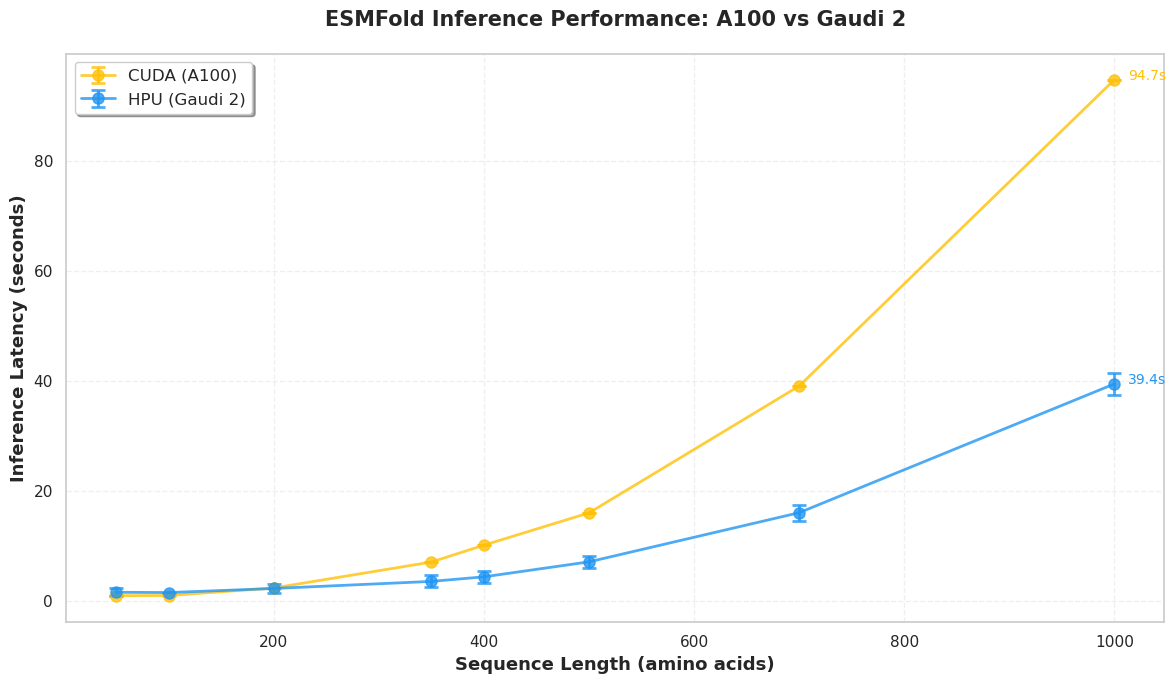

Plot saved as 'latency_comparison.png'


In [5]:
fig, ax = plt.subplots(figsize=(12, 7))

# Latency Plot
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    
    ax.errorbar(
        device_data['length'],
        device_data['latency_mean'],
        yerr=device_data['latency_std'],
        marker='o',
        markersize=8,
        linewidth=2,
        capsize=5,
        capthick=2,
        label=device,
        color=device_colors[device],
        alpha=0.8
    )

ax.set_xlabel('Sequence Length (amino acids)', fontsize=13, fontweight='bold')
ax.set_ylabel('Inference Latency (seconds)', fontsize=13, fontweight='bold')
ax.set_title('ESMFold Inference Performance: A100 vs Gaudi 2', fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')

# Annotations
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    last_point = device_data.iloc[-1]
    ax.annotate(
        f"{last_point['latency_mean']:.1f}s",
        xy=(last_point['length'], last_point['latency_mean']),
        xytext=(10, 0),
        textcoords='offset points',
        fontsize=10,
        color=device_colors[device],
        alpha=1.0
    )

plt.tight_layout()
plt.savefig('latency_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'latency_comparison.png'")

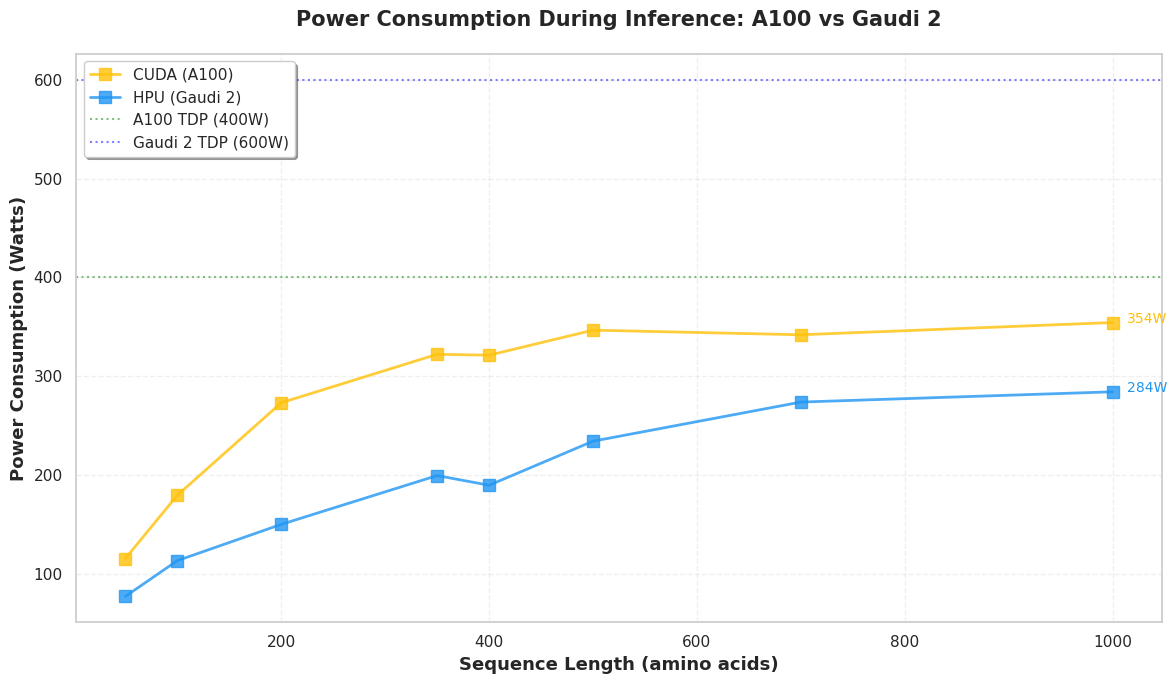

Plot saved as 'power_comparison.png'


In [6]:
fig, ax = plt.subplots(figsize=(12, 7))

# Power consumption plot
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    
    ax.plot(
        device_data['length'],
        device_data['power_mean'],
        marker='s',
        markersize=8,
        linewidth=2,
        label=device,
        color=device_colors[device],
        alpha=0.8
    )

ax.set_xlabel('Sequence Length (amino acids)', fontsize=13, fontweight='bold')
ax.set_ylabel('Power Consumption (Watts)', fontsize=13, fontweight='bold')
ax.set_title('Power Consumption During Inference: A100 vs Gaudi 2', fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')

# TDP reference markers
ax.axhline(y=400, color='green', linestyle=':', alpha=0.5, linewidth=1.5, label='A100 TDP (400W)')
ax.axhline(y=600, color='blue', linestyle=':', alpha=0.5, linewidth=1.5, label='Gaudi 2 TDP (600W)')
ax.legend(fontsize=11, loc='upper left', frameon=True, shadow=True)

# Annotations
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    last_point = device_data.iloc[-1]
    ax.annotate(
        f"{last_point['power_mean']:.0f}W",
        xy=(last_point['length'], last_point['power_mean']),
        xytext=(10, 0),
        textcoords='offset points',
        fontsize=10,
        color=device_colors[device],
        alpha=1.0
    )

plt.tight_layout()
plt.savefig('power_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'power_comparison.png'")

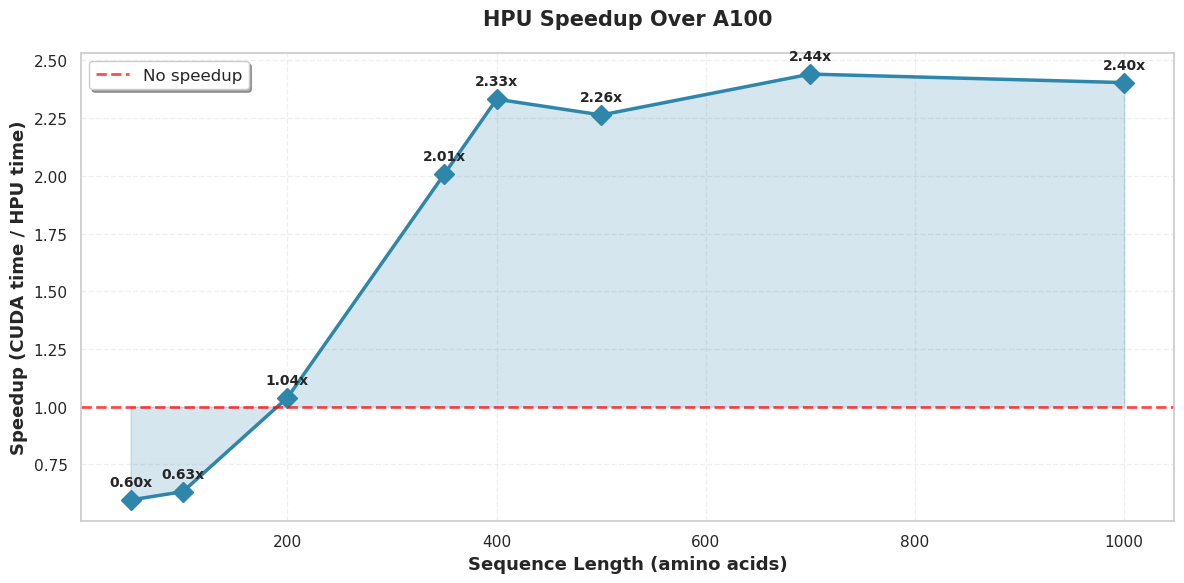


Speedup Summary:
         Speedup
length          
50      0.595729
100     0.631624
200     1.039479
350     2.008030
400     2.332117
500     2.263687
700     2.440814
1000    2.403884

Average speedup: 1.71x
Max speedup: 2.44x at 700 amino acids


In [7]:
# Speedup = CUDA time / HPU time
cuda_latencies = cuda_df.set_index('length')['latency_mean']
hpu_latencies = hpu_df.set_index('length')['latency_mean']

speedup = cuda_latencies / hpu_latencies

# Speedup plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(speedup.index, speedup.values, marker='D', markersize=10, linewidth=2.5, color='#2E86AB')
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='No speedup')
ax.fill_between(speedup.index, 1, speedup.values, alpha=0.2, color='#2E86AB')

ax.set_xlabel('Sequence Length (amino acids)', fontsize=13, fontweight='bold')
ax.set_ylabel('Speedup (CUDA time / HPU time)', fontsize=13, fontweight='bold')
ax.set_title('HPU Speedup Over A100', fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')

# Annotations
for length, speed in speedup.items():
    ax.annotate(
        f"{speed:.2f}x",
        xy=(length, speed),
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=10,
        ha='center',
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSpeedup Summary:")
print(speedup.to_frame(name='Speedup'))
print(f"\nAverage speedup: {speedup.mean():.2f}x")
print(f"Max speedup: {speedup.max():.2f}x at {speedup.idxmax()} amino acids")

In [8]:
# Summary Table
summary = df.pivot_table(
    index='length',
    columns='device',
    values=['latency_mean', 'power_mean', 'throughput']
).round(2)

print("\n" + "="*80)
print("BENCHMARK SUMMARY")
print("="*80)
print(summary)
print("="*80)


BENCHMARK SUMMARY
       latency_mean                power_mean                throughput  \
device  CUDA (A100) HPU (Gaudi 2) CUDA (A100) HPU (Gaudi 2) CUDA (A100)   
length                                                                    
50             0.90          1.52      115.95         77.64        1.11   
100            0.92          1.46      179.90        113.80        1.08   
200            2.29          2.21      273.39        150.46        0.44   
350            7.01          3.49      322.36        199.78        0.14   
400           10.08          4.32      321.46        190.00        0.10   
500           15.95          7.05      346.75        234.53        0.06   
700           39.01         15.98      342.08        274.07        0.03   
1000          94.70         39.40      354.46        284.45        0.01   

                      
device HPU (Gaudi 2)  
length                
50              0.66  
100             0.68  
200             0.45  
350             0

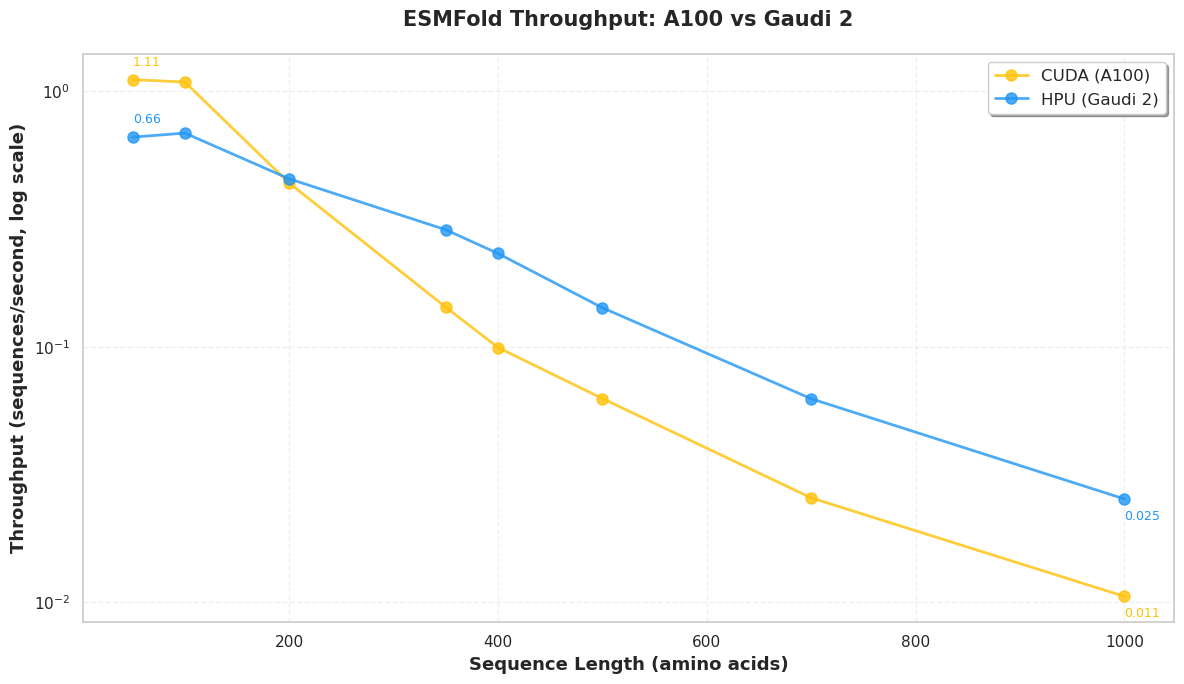

Plot saved as 'throughput_comparison.png'


In [9]:
fig, ax = plt.subplots(figsize=(12, 7))

# Throughput plot as 1/latency = sequences per second
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    
    # Calculate inverse latency (throughput)
    throughput = 1 / device_data['latency_mean']
    
    ax.plot(
        device_data['length'],
        throughput,
        marker='o',
        markersize=8,
        linewidth=2,
        label=device,
        color=device_colors[device],
        alpha=0.8
    )

ax.set_xlabel('Sequence Length (amino acids)', fontsize=13, fontweight='bold')
ax.set_ylabel('Throughput (sequences/second)', fontsize=13, fontweight='bold')
ax.set_title('ESMFold Throughput: A100 vs Gaudi 2', fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')

# Log scale plot
ax.set_yscale('log')
ax.set_ylabel('Throughput (sequences/second, log scale)', fontsize=13, fontweight='bold')

# Annotations
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    throughput = 1 / device_data['latency_mean']
    
    first_point = device_data.iloc[0]
    last_point = device_data.iloc[-1]
    
    ax.annotate(
        f"{1/first_point['latency_mean']:.2f}",
        xy=(first_point['length'], 1/first_point['latency_mean']),
        xytext=(0, 10),
        textcoords='offset points',
        color=device_colors[device],
        fontsize=9,
        alpha=1.0
    )
    
    ax.annotate(
        f"{1/last_point['latency_mean']:.3f}",
        xy=(last_point['length'], 1/last_point['latency_mean']),
        xytext=(0, -15),
        textcoords='offset points',
        color=device_colors[device],
        fontsize=9,
        alpha=1.0
    )

plt.tight_layout()
plt.savefig('throughput_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'throughput_comparison.png'")

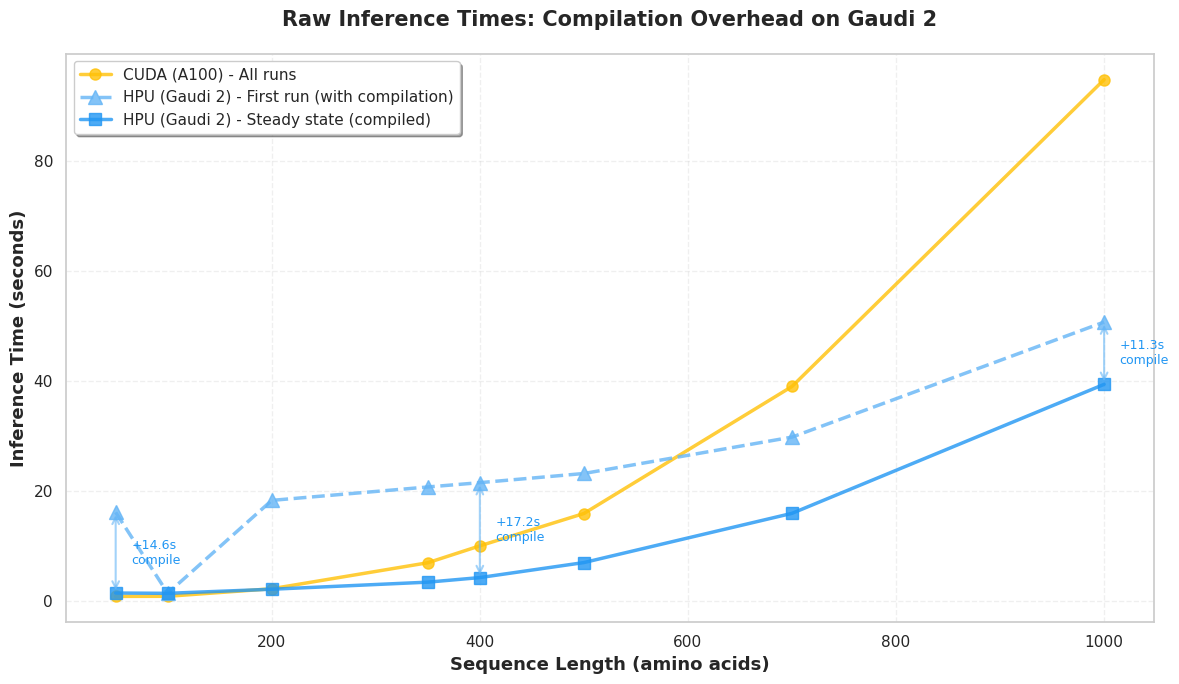


COMPILATION OVERHEAD ANALYSIS
 Sequence Length  First Run (s)  Steady State (s)  Compilation Overhead (s)  Overhead (%)
              50      16.166394          1.516989                 14.649405          90.6
             100       1.476221          1.462140                  0.014081           1.0
             200      18.333182          2.207135                 16.126047          88.0
             350      20.767077          3.492317                 17.274760          83.2
             400      21.550175          4.322168                 17.228007          79.9
             500      23.214407          7.046340                 16.168067          69.6
             700      29.815726         15.980993                 13.834733          46.4
            1000      50.701737         39.395798                 11.305939          22.3

Average compilation overhead: 13.33s
Average overhead percentage: 60.1%

Note: After first run, HPU maintains 1.71x speedup over A100


In [11]:
## 8. Plot: Raw Inference Times - First Run vs Steady State

fig, ax = plt.subplots(figsize=(12, 7))

# CUDA plot (no compilation overhead)
cuda_device = cuda_df
ax.plot(
    cuda_device['length'],
    cuda_device['latency_mean'],
    marker='o',
    markersize=8,
    linewidth=2.5,
    label='CUDA (A100) - All runs',
    alpha=0.8,
    color='#FFC107'
)

# HPU first run plot (with compilation)
hpu_device = hpu_df
ax.plot(
    hpu_device['length'],
    hpu_device['compile_time'],
    marker='^',
    markersize=10,
    linewidth=2.5,
    label='HPU (Gaudi 2) - First run (with compilation)',
    alpha=0.8,
    linestyle='--',
    color='#64B5F6'
)

# HPU steady state plot (without compilation)
ax.plot(
    hpu_device['length'],
    hpu_device['latency_mean'],
    marker='s',
    markersize=8,
    linewidth=2.5,
    label='HPU (Gaudi 2) - Steady state (compiled)',
    alpha=0.8,
    color='#2196F3'
)

ax.set_xlabel('Sequence Length (amino acids)', fontsize=13, fontweight='bold')
ax.set_ylabel('Inference Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Raw Inference Times: Compilation Overhead on Gaudi 2', fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')

# Annotations
for idx in [0, len(hpu_device)//2, -1]:  # First, middle, last
    point = hpu_device.iloc[idx]
    overhead = point['compile_time'] - point['latency_mean']
    
    ax.annotate(
        '',
        xy=(point['length'], point['latency_mean']),
        xytext=(point['length'], point['compile_time']),
        arrowprops=dict(arrowstyle='<->', color='#64B5F6', lw=1.5, alpha=0.6)
    )
    
    ax.text(
        point['length'] + 15,
        (point['compile_time'] + point['latency_mean']) / 2,
        f"+{overhead:.1f}s\ncompile",
        fontsize=9,
        color='#2196F3',
        alpha=1.0,
        va='center'
    )

plt.tight_layout()
plt.savefig('compilation_overhead.png', dpi=300, bbox_inches='tight')
plt.show()

# Compilation overhead summary
print("\n" + "="*80)
print("COMPILATION OVERHEAD ANALYSIS")
print("="*80)

overhead_summary = pd.DataFrame({
    'Sequence Length': hpu_device['length'],
    'First Run (s)': hpu_device['compile_time'],
    'Steady State (s)': hpu_device['latency_mean'],
    'Compilation Overhead (s)': hpu_device['compile_time'] - hpu_device['latency_mean'],
    'Overhead (%)': ((hpu_device['compile_time'] - hpu_device['latency_mean']) / hpu_device['compile_time'] * 100).round(1)
})

print(overhead_summary.to_string(index=False))
print("="*80)
print(f"\nAverage compilation overhead: {overhead_summary['Compilation Overhead (s)'].mean():.2f}s")
print(f"Average overhead percentage: {overhead_summary['Overhead (%)'].mean():.1f}%")
print(f"\nNote: After first run, HPU maintains {(cuda_device['latency_mean'] / hpu_device['latency_mean']).mean():.2f}x speedup over A100")

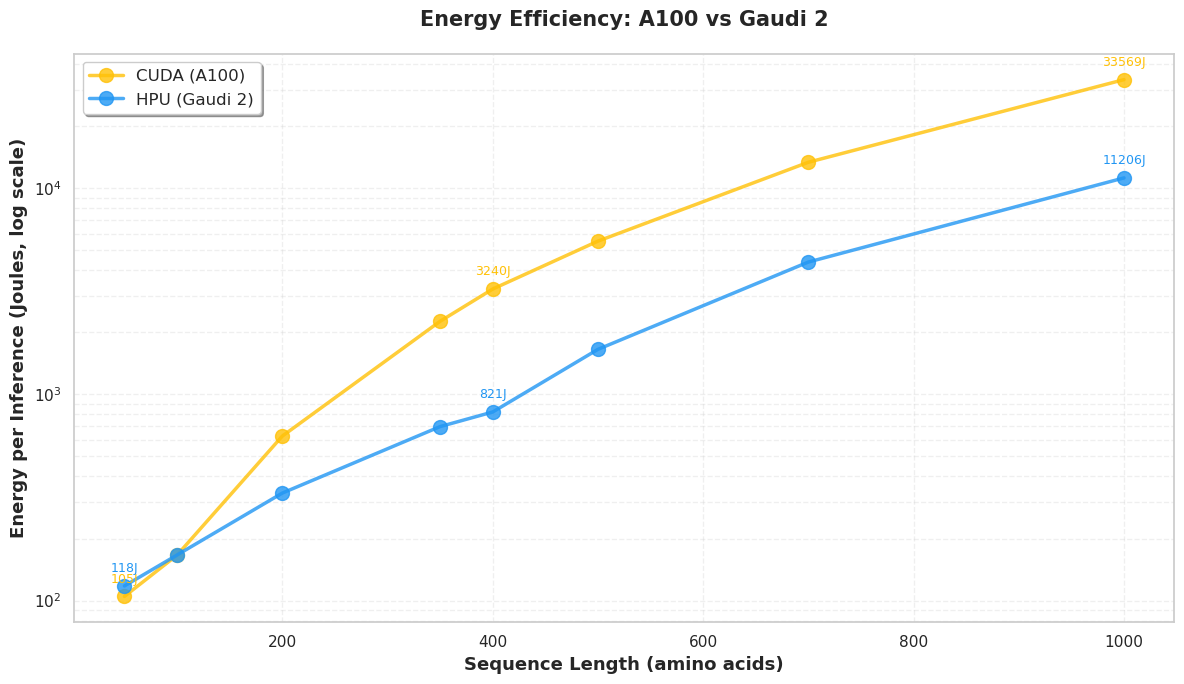


ENERGY EFFICIENCY SUMMARY (Joules per sequence)
device  CUDA (A100)  HPU (Gaudi 2)  HPU Savings (%)
length                                             
50            104.8          117.8            -12.4
100           166.1          166.4             -0.2
200           627.2          332.1             47.1
350          2260.6          697.7             69.1
400          3240.2          821.2             74.7
500          5530.9         1652.6             70.1
700         13343.3         4379.9             67.2
1000        33568.8        11206.2             66.6

Average energy savings with HPU: 47.8%
Crossover point: 50 amino acids (HPU becomes more efficient)


In [12]:
# Energy consumption as Power × Time = Joules
df['energy_joules'] = df['power_mean'] * df['latency_mean']

fig, ax = plt.subplots(figsize=(12, 7))

# Energy consumption plot
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    
    ax.plot(
        device_data['length'],
        device_data['energy_joules'],
        marker='o',
        markersize=10,
        linewidth=2.5,
        label=device,
        color=device_colors[device],
        alpha=0.8
    )

ax.set_xlabel('Sequence Length (amino acids)', fontsize=13, fontweight='bold')
ax.set_ylabel('Energy per Inference (Joules, log scale)', fontsize=13, fontweight='bold')
ax.set_title('Energy Efficiency: A100 vs Gaudi 2', fontsize=15, fontweight='bold', pad=20)
ax.set_yscale('log')  # ADD THIS LINE for logarithmic scale
ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--', which='both')  # Show grid for both major and minor ticks

# Annotations
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    
    for idx in [0, len(device_data)//2, -1]:  # First, middle, last
        point = device_data.iloc[idx]
        ax.annotate(
            f"{point['energy_joules']:.0f}J",
            xy=(point['length'], point['energy_joules']),
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=9,
            color=device_colors[device],
            alpha=1.0,
            ha='center'
        )

plt.tight_layout()
plt.savefig('energy_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

# Energy efficiency summary
print("\n" + "="*80)
print("ENERGY EFFICIENCY SUMMARY (Joules per sequence)")
print("="*80)

energy_summary = df.pivot_table(
    index='length',
    columns='device',
    values='energy_joules'
).round(1)

# Calculate energy savings (approx.)
energy_summary['HPU Savings (%)'] = (
    (energy_summary['CUDA (A100)'] - energy_summary['HPU (Gaudi 2)']) / 
    energy_summary['CUDA (A100)'] * 100
).round(1)

print(energy_summary)
print("="*80)
print(f"\nAverage energy savings with HPU: {energy_summary['HPU Savings (%)'].mean():.1f}%")

if (energy_summary['HPU Savings (%)'] < 0).any():
    crossover = energy_summary[energy_summary['HPU Savings (%)'] < 0].index[0]
    print(f"Crossover point: {crossover} amino acids (HPU becomes more efficient)")
else:
    print("HPU is more energy efficient across all sequence lengths")

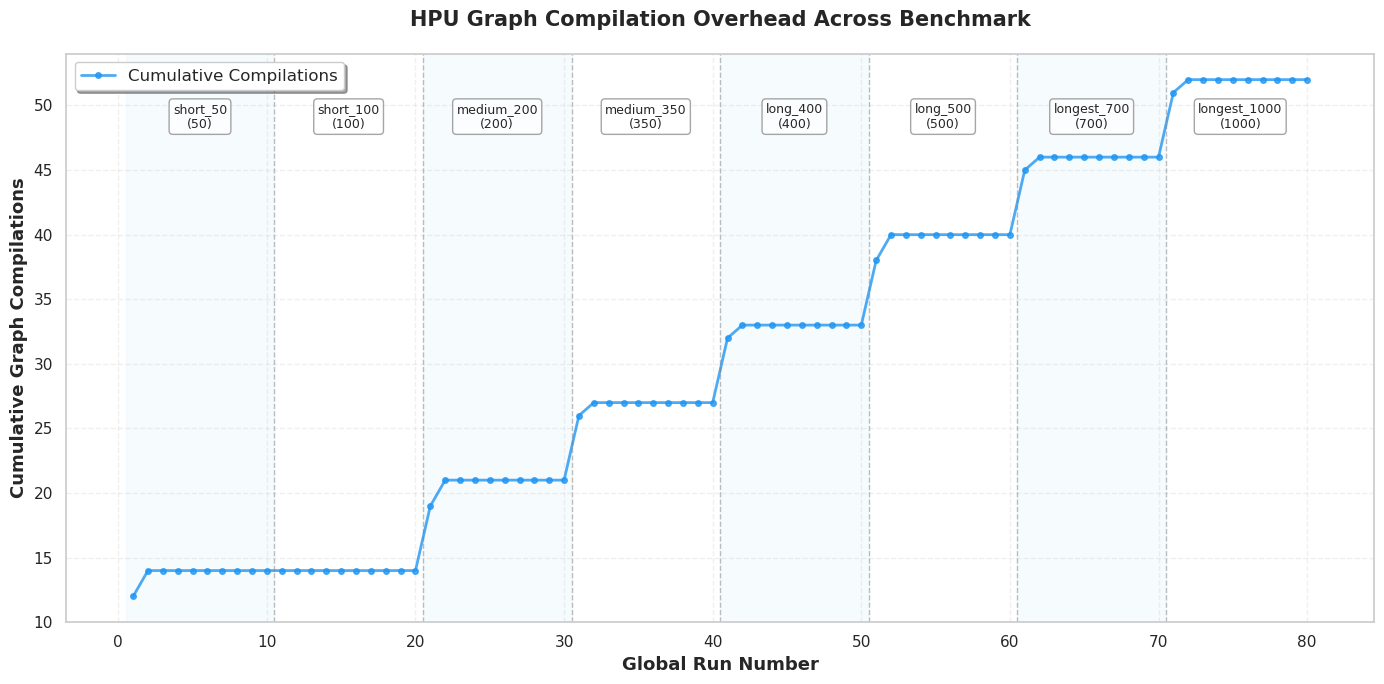


GRAPH COMPILATION SUMMARY
    Sequence  Initial Compilations  Final Compilations  Length  New Compilations
    long_400                    32                  33     400                 1
    long_500                    38                  40     500                 2
longest_1000                    51                  52    1000                 1
 longest_700                    45                  46     700                 1
  medium_200                    19                  21     200                 2
  medium_350                    26                  27     350                 1
   short_100                    14                  14     100                 0
    short_50                    12                  14      50                 2

Total compilations across all sequences: 52
Total benchmark runs: 80


In [18]:
fig, ax = plt.subplots(figsize=(14, 7))

# Cumulative compilations plot
ax.plot(
    compilation_df['global_run'],
    compilation_df['cumulative_compilations'],
    marker='o',
    markersize=4,
    linewidth=2,
    color='#2196F3',  # Blue for Gaudi
    alpha=0.8,
    label='Cumulative Compilations'
)

# Add shaded regions and labels for each sequence
sequences = compilation_df.groupby('sequence_name', sort=False)
colors_cycle = ['#E3F2FD', '#FFFFFF']  # Light blue and white alternating

run_start = 1
for idx, (seq_name, group) in enumerate(sequences):
    run_end = run_start + len(group) - 1
    seq_length = group['sequence_length'].iloc[0]
    
    ax.axvspan(run_start - 0.5, run_end + 0.5, 
               alpha=0.3, 
               color=colors_cycle[idx % 2],
               zorder=0)
    
    if run_start > 1:
        ax.axvline(x=run_start - 0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    mid_point = (run_start + run_end) / 2
    ax.text(mid_point, ax.get_ylim()[1] * 0.93, 
            f'{seq_name}\n({seq_length})',
            ha='center', va='top',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.7))
    
    run_start = run_end + 1

ax.set_xlabel('Global Run Number', fontsize=13, fontweight='bold')
ax.set_ylabel('Cumulative Graph Compilations', fontsize=13, fontweight='bold')
ax.set_title('HPU Graph Compilation Overhead Across Benchmark', fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

ax.set_xticks(range(0, len(compilation_df) + 1, 10))

plt.tight_layout()
plt.savefig('graph_compilation_overhead.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n" + "="*80)
print("GRAPH COMPILATION SUMMARY")
print("="*80)

compilation_summary = compilation_df.groupby('sequence_name').agg({
    'cumulative_compilations': ['first', 'last'],
    'sequence_length': 'first'
}).reset_index()

compilation_summary.columns = ['Sequence', 'Initial Compilations', 'Final Compilations', 'Length']
compilation_summary['New Compilations'] = (
    compilation_summary['Final Compilations'] - compilation_summary['Initial Compilations']
)

print(compilation_summary.to_string(index=False))
print("="*80)
print(f"\nTotal compilations across all sequences: {compilation_df['cumulative_compilations'].iloc[-1]}")
print(f"Total benchmark runs: {len(compilation_df)}")